# Correlation between the scores

In [ ]:
# Required Libraries
import pandas as pd
import requests
import time

# Fetch Countries Based on Partner Data
def fetch_countries(api_key):
    headers = {"Ocp-Apim-Subscription-Key": api_key}
    url = "https://comtradeapi.un.org/data/v1/get/C/A/HS"
    params = {
        "reporterCode": "",  # UK as sample
        "period": 2022,
        "flowCode": "M",
        "cmdCode": "TOTAL",
        "freq": "A",
        "breakdownMode": "classic",
        "includeDesc": True
    }
    try:
        res = requests.get(url, params=params, headers=headers)
        if res.status_code == 200:
            data = res.json().get("data", [])
            partners = sorted(list({
                rec["partnerCode"]: rec["partnerDesc"]
                for rec in data if rec.get("partnerCode") and rec.get("partnerDesc")
            }.items()), key=lambda x: x[1])
            return [{"label": f"{name} ({code})", "value": str(code)} for code, name in partners]
    except Exception as e:
        print("❌ Exception while fetching countries:", e)
    return []

# === Helper Functions ===
def fetch_comtrade_data(params, api_key, retries=3):
    headers = {"Ocp-Apim-Subscription-Key": api_key}
    for attempt in range(retries):
        try:
            response = requests.get("https://comtradeapi.un.org/data/v1/get/C/A/HS", params=params, headers=headers)
            if response.status_code == 200:
                return response.json().get("data", [])
            elif response.status_code == 429:
                time.sleep(5 * (attempt + 1))
        except requests.exceptions.RequestException as e:
            print("Connection error:", e)
    return []

def is_valid_partner(partner):
    if not partner:
        return False
    partner = partner.lower()
    return not any(x in partner for x in ["world"])

def get_trade_partners(reporter, flow, hs_code, year, api_key):
    params = {
        "reporterCode": reporter,
        "period": year,
        "flowCode": flow,
        "cmdCode": hs_code,
        "freq": "A",
        "breakdownMode": "classic",
        "includeDesc": True
    }
    data = fetch_comtrade_data(params, api_key)
    partner_values = {}
    for rec in data:
        partner = rec.get("partnerDesc")
        value = rec.get("primaryValue")
        if is_valid_partner(partner) and value:
            try:
                val = float(value)
                if val > 0:
                    partner_values[partner] = partner_values.get(partner, 0) + val
            except ValueError:
                continue
    return partner_values

def calculate_scri(imports, exports):
    M = sum(imports.values())
    X = sum(exports.values())
    N = len(imports)
    HHI = sum((v / M) ** 2 for v in imports.values()) if M > 0 else 0.0
    DiversityScore = min(N / 193.0, 1.0)
    IDI = max(min((M - X) / M, 1.0), 0.0) if M > 0 else 0.0
    SCRI = round(HHI * (1 - DiversityScore) * IDI, 4)
    return {
        "Total Imports": M,
        "Total Exports": X,
        "HHI": round(HHI, 4),
        "Diversity Score": round(DiversityScore, 4),
        "IDI": round(IDI, 4),
        "SCRI": SCRI,
        "Import Partners": N
    }


In [ ]:
api_key = "" # Enter your api_key here
# Get the list of countries
countries = fetch_countries(api_key)

In [64]:
# Get the scores for 100 countries
scri_dict = {}
hs_code = 8541 # Semiconductors
year = 2022
for country in countries[:100]:
    import_data = get_trade_partners(country['value'], "M", hs_code, year, api_key)
    export_data = get_trade_partners(country['value'], "X", hs_code, year, api_key)
    # Append the score only if import and export data exist
    if import_data and export_data:
        scri_result = calculate_scri(import_data, export_data)
        scri_dict[country['label']] = scri_result

In [100]:
# Check the number of countries for which the score is calculated
print("Number of countries for which the scores were calculated :", len(scri_dict))

Number of countries for which the scores were calculated : 58


In [87]:
# Calculate the correlation matrix
filtered_scores = [
    {
        'HHI': scores['HHI'],
        'Diversity_score': scores['Diversity Score'],
        'IDI': scores['IDI']
    }
    for scores in scri_dict.values()
]
scores_df = pd.DataFrame(filtered_scores)
correlation_matrix = scores_df.corr()
print(correlation_matrix)

                      HHI  Diversity_score       IDI
HHI              1.000000        -0.155706  0.211874
Diversity_score -0.155706         1.000000 -0.548356
IDI              0.211874        -0.548356  1.000000


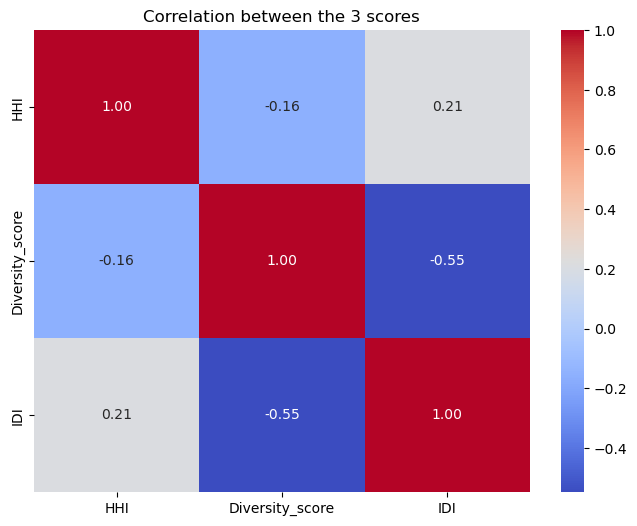

In [89]:
# Plot the correlation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between the 3 scores')
plt.show()

To ensure the three chosen metrics - Herfindahl-Hirschman Index (HHI), Supplier Diversity Score (S), and Import Dependency Index (IDI) add unique value to the final risk calculation, a correlation analysis was carried out. We began with data for 100 countries for trade of semiconductors in the year 2022, of which 58 had sufficient import-export data. For these, the three scores were computed and compared.

The goal was to assess whether any of the metrics were redundant—that is, if two scores were highly correlated, they might be capturing the same aspect of supply chain risk. The highest observed correlation was –0.55 between IDI and the diversity score, suggesting that in some cases, countries that rely heavily on imports may also tend to have fewer supplier sources. However, this correlation was moderate at best and not strong enough to justify removing either variable. The remaining correlations were even lower, supporting the decision to retain all three scores.

This multiplicative approach ensures that high risk only emerges when all three factors contribute, and that low risk in one dimension can offset vulnerabilities in another. It reflects the compounding nature of supply chain risk and keeps the score within a clear 0–1 range.